In [1]:
#necessary imports
import pennylane as qml
from pennylane import qaoa
import tensorflow as tf
import networkx as nx
import numpy as np 
from matplotlib import pyplot as plt
import random

#fixing seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#use networkx to generate random graphs to train on

def generate_graphs(n_graphs, n_nodes, p_edge):
    
    datapoints = []
    for n in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p=p_edge)
        datapoints.append(random_graph)
    return datapoints



In [3]:
def qaoa_from_graph(graph, n_layers):
    
    wires = range(len(graph.nodes))
    
    cost_h, mixer_h = qaoa.maxcut(graph)
    
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
        
    def circuit(params, **kwargs):
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
        return qml.expval(cost_h)
    
    def hamiltonian(params, **kwargs):
        
        dev = qml.device('default.qubit.tf', wires=len(graph.nodes))
        
        cost = qml.QNode(circuit, dev, interface='tf', diff_method='backprop')
        
        return cost(params)
    
    return hamiltonian

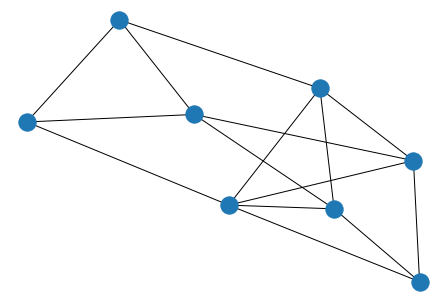

In [4]:
#let's take a look at how this works

n_graphs = 30
n_nodes = 8
p_edge = 3.0 / n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

nx.draw(graphs[0])

In [5]:
cost = qaoa_from_graph(graph=graphs[0], n_layers=1)

x = tf.Variable([[0.5], [0.5]], dtype=tf.float32)

print(cost(x))

tf.Tensor(-4.512936901132845, shape=(), dtype=float64)


In [6]:
#Let's create an LSTM model that is able to handle both quantum and classical data in a hybrid model

n_layers = 1

cell = tf.keras.layers.LSTMCell(2 * n_layers)

In [7]:
graph_cost_list = [qaoa_from_graph(g, n_layers) for g in graphs]

In [8]:
#create a function that will perform one time step of the RNN

def rnn_iteration(inputs, graph_cost, n_layers=1):
    
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]
    
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
    
    new_params, [new_h, new_c] = cell(new_input, states=[prev_h, prev_c])
    
    _params = tf.reshape(new_params, shape=(2, n_layers))

    _cost = graph_cost(_params)
    
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape=(1, 1))
    
    return [new_cost, new_params, new_h, new_c]

#create a function for a recurrent loop

def recurrent_loop(graph_cost, n_layers=1, intermediate_steps=False):
    
    initial_cost = tf.zeros(shape=(1, 1))
    initial_params = tf.zeros(shape=(1, 2 * n_layers))
    initial_h = tf.zeros(shape=(1, 2 * n_layers))
    initial_c = tf.zeros(shape=(1, 2 * n_layers))
    
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)
    
    loss = tf.keras.layers.average(
        [0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]]
    )
    
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], out4[1], loss]
    else:
        return loss

In [9]:
#create a single gradient descent step

def train_step(graph_cost):
    
    with tf.GradientTape() as tape:
        
        loss = recurrent_loop(graph_cost)
        
    grads = tape.gradient(loss, cell.trainable_weights)
    
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

In [10]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

epochs = 5

for epoch in range(epochs):
    print(f'Epoch {epoch+1}')
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        
        if i % 5 == 0:
            print(f'> Graph {i + 1}/{len(graph_cost_list)} - Loss: {loss[0][0]}')
        
    print(f'>> Mean loss during epoch: {np.mean(total_loss)}')

Epoch 1
> Graph 1/30 - Loss: -2.2527360916137695
> Graph 6/30 - Loss: -2.232595920562744
> Graph 11/30 - Loss: -2.0134263038635254
> Graph 16/30 - Loss: -1.421688437461853
> Graph 21/30 - Loss: -1.4320094585418701
> Graph 26/30 - Loss: -2.217761516571045
>> Mean loss during epoch: -1.9250328501065572
Epoch 2
> Graph 1/30 - Loss: -2.7025058269500732
> Graph 6/30 - Loss: -2.431377410888672
> Graph 11/30 - Loss: -2.2624270915985107
> Graph 16/30 - Loss: -1.4723050594329834
> Graph 21/30 - Loss: -1.4549248218536377
> Graph 26/30 - Loss: -2.227466106414795
>> Mean loss during epoch: -2.0067639350891113
Epoch 3
> Graph 1/30 - Loss: -2.769179344177246
> Graph 6/30 - Loss: -2.442570209503174
> Graph 11/30 - Loss: -2.2650725841522217
> Graph 16/30 - Loss: -1.474663496017456
> Graph 21/30 - Loss: -1.45889151096344
> Graph 26/30 - Loss: -2.2253408432006836
>> Mean loss during epoch: -2.0163506110509237
Epoch 4
> Graph 1/30 - Loss: -2.7873682975769043
> Graph 6/30 - Loss: -2.4413390159606934
> Gra

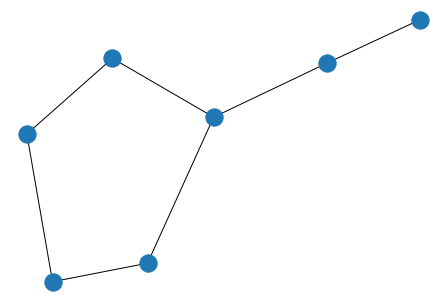

In [16]:
#Let's see how well our model works

new_graph = nx.gnp_random_graph(7, p=3/ 7)
new_cost = qaoa_from_graph(new_graph, n_layers=1)

nx.draw(new_graph)

In [17]:
result = recurrent_loop(new_cost, intermediate_steps=True)

start_zeros = tf.zeros(shape=(2 * n_layers, 1))
guess_0 = result[0]
guess_1 = result[1]
guess_2 = result[2]
guess_3 = result[3]
guess_4 = result[4]
final_loss = result[5]

guesses = [start_zeros, guess_0, guess_1, guess_2, guess_3, guess_4]

lstm_losses = [new_cost(tf.reshape(guess, shape=(2, n_layers))) for guess in guesses]

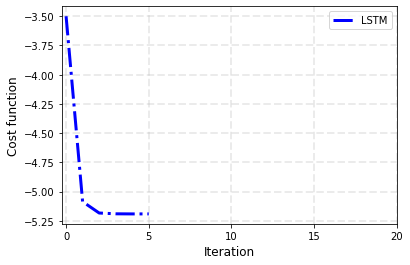

In [18]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color='blue', lw=3, ls='-.', label='LSTM')

plt.grid(ls='--', lw=2, alpha=0.25)
plt.ylabel('Cost function', fontsize=12)
plt.xlabel('Iteration', fontsize=12)
plt.legend()
ax.set_xticks([0, 5, 10, 15, 20]);
plt.show()

In [21]:
# How did the RNN optimization perform against other techniques, like Stochastic Gradient Descent

x = tf.Variable(np.random.rand(2, 1))

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

steps = []
sdg_losses = []
for s in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x)
        
    steps.append(x)
    sdg_losses.append(loss)
    
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f'Step {s+1} - Loss = {loss}')
    
print(f'Final Cost Function: {new_cost(x).numpy()}\nOptimizsed angles: {x.numpy()}')

Step 1 - Loss = -1.8353040534446194
Step 2 - Loss = -1.8471836065737113
Step 3 - Loss = -1.8655025814811854
Step 4 - Loss = -1.893895838994193
Step 5 - Loss = -1.9379117731282303
Step 6 - Loss = -2.0057735396102263
Step 7 - Loss = -2.1090828439135585
Step 8 - Loss = -2.262873930023056
Step 9 - Loss = -2.483762184638653
Step 10 - Loss = -2.784366253186505
Step 11 - Loss = -3.163200499778251
Step 12 - Loss = -3.5941219356532312
Step 13 - Loss = -4.0264403962575095
Step 14 - Loss = -4.4041061432680095
Step 15 - Loss = -4.692511994943326
Final Cost Function: -4.889032346125357
Optimizsed angles: [[ 0.85908533]
 [-0.24600869]]


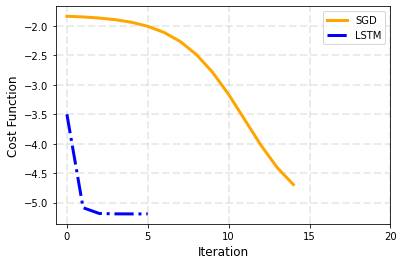

In [22]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color='orange', lw=3, label='SGD')

plt.plot(lstm_losses, color='blue', lw=3, ls='-.', label='LSTM')

plt.grid(ls='--', lw=2, alpha=0.25)
plt.legend()
plt.ylabel('Cost Function', fontsize=12)
plt.xlabel('Iteration', fontsize=12)
ax.set_xticks([0, 5, 10, 15, 20])
plt.show()